In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import breastcancer_utils as bcu

## Import data

In [2]:
filename = 'wdbc_M1_B0.data'
X,Y = bcu.load_breastcancer(filename)
n = len(X)

## Sub-gradient method

### Question 2.1

### Question 2.2

In [3]:
def h(z):
    return np.maximum(np.zeros(z.shape),1-z)

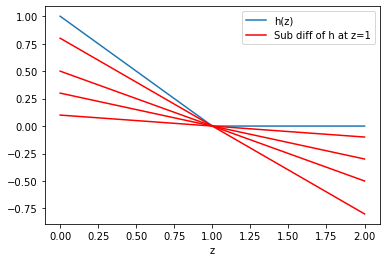

In [4]:
x = np.linspace(0,2,100)
z_1 = -0.8*x + 0.8
z_2 = -0.5*x + 0.5
z_3 = -0.3*x + 0.3
z_4 = -0.1*x + 0.1
y = h(x)
plt.plot(x,y, label='h(z)')
plt.plot(x, z_1, c='red', label='Sub diff of h at z=1')
plt.plot(x,z_2, c='red')
plt.plot(x,z_3, c='red')
plt.plot(x, z_4, c='red')
plt.xlabel('z')
plt.legend()

For $z<1$, h is differentiable so $\partial h(z)=\{\nabla h(z)\}$ and $\nabla{h}(z)=-1$ so for $z<1, \partial h(z)=\{-1\}$.

For $z>1$, h is differentiable so $\partial h(z)=\{\nabla h(z)\}$ and $\nabla{h}(z)=0$ so for $z>1, \partial h(z)=\{0\}$.

For $z=1$, h is not differentiable but every tangent in $z=1$ with a slope in $[-1,0]$ is a sub-gradient of $h$ at $z=1$, as they are the only ones under the curve of $h$. Therefore, $\partial h(1)=[-1,0]$.

### Question 2.3

$\displaystyle N(v,a)=\frac{1}{2}\sum_{j=1}^{m} v_j^2$

$\displaystyle M(v,a)=Diag(Y)(X^Tv + a\mathbb{1}_{n})$

$\displaystyle H(u)=\sum_{i=1}^{n} max(0,1-u_i)$

$N$ is separable as it is the sum of the coefficients of $v$ squared, M is linear and H is also separable.

Therefore, we have that: $f(v,a)=N(v, a)+cH(M(v, a))$

$\displaystyle \partial N=\{\nabla N\}$ because it is differentiable. $\nabla N(v,a)=(v,0)$

$\displaystyle \partial H(u)=\prod_{i=1}^{n} \partial h(u_i)$ because $H$ is separable and $h$ is the function of the question 2.2.

### Question 2.4

In [5]:
def H(u):
    return np.sum(h(u))

def objective_function(va, c, M):
    N = 1/2 * np.sum(va[:-1]**2)
    sub_grad_H = []
    M_va = M@va
    sub_grad_H = np.dot(M.T, (M_va>=1)- 1)
    return N + c * H(M_va), np.concatenate([va[:-1], [0]]) + c * sub_grad_H

In [6]:
M = np.dot(np.diag(Y), np.concatenate([X, np.ones((569,1))], axis = 1))
va = np.zeros(31)
print(objective_function(va,1,M))

(569.0, array([-401.67227502, -228.44097367, -408.60883936, -390.09318973,
       -197.28489321, -328.22148127, -383.14721063, -427.3041985 ,
       -181.84509798,    7.0634352 , -312.04525371,    4.56861423,
       -305.99668108, -301.64736575,   36.873181  , -161.21243374,
       -139.60579724, -224.51080955,    3.58836467,  -42.90155493,
       -427.21613038, -251.39455908, -430.77071337, -403.76117734,
       -231.89607933, -325.17580208, -362.92710448, -436.63153222,
       -229.05116772, -178.19917556,  145.        ]))


### Question 2.5

In [7]:
def subgrad_method(va0, nb_iter, M):
    gamma_sum, va_moy = 0, np.zeros(len(va0))
    for i in range(nb_iter):
        gamma = 0.001/np.sqrt(i+1)
        gamma_sum += gamma
        va_moy += gamma * va0
        sub_grad = objective_function(va0, 1, M)[1]
        va0 = va0 - gamma * sub_grad
    return va_moy/gamma_sum

In [8]:
va_min = subgrad_method(va, int(1e5), M)
print('The minimum of the objective function is', objective_function(va_min, 1, M)[0])

The minimum of the objective function is 28.087767544895126


The method is very slow to converge when using $\gamma_k=\frac{1}{k+1}$ (it does not converge to a minimum of the objective function with $100~000$ iterations). When using $\gamma_k=\frac{1}{\sqrt{k+1}}$, the convergence is better (it is the gamma used in the lecture notes).

## Stochastic subgradient method 

### Question 3.1

$\displaystyle \begin{array}{} \mathbb{E}\left[f_I(v,a)\right] =\mathbb{E}\left(\sum_{i=1}^{n}f_i(v,a)\mathbb{P}(I=i)\right)=\sum_{i=1}^{n}\mathbb{E}\left(f_i(v,a)\mathbb{P}(I=i)\right)=\frac{1}{n}\sum_{i=1}^{n}\mathbb{E}\left(f_i(v,a)\right)=\frac{1}{n}\sum_{i=1}^{n}f_i(v,a)=f(v,a) \end{array}$

### Question 3.2

$M_i(v,a)=y_i(x_i^Tv+a)$, therefore $M_i=y_i(x_i^T,1)$ which is the $i^{th}$ line of M.

$\partial f_i(v,a) = \left \{ \begin{array} {} \{(v,0) - ncM_i^T\} & if \, M_i(v,a) \lt 1 \\ \{(v,0) + tncM_i^t,\,t \in [-1;0]\} & if \, M_i(v,a) = 1 \\ \{(v,0)\} & if \, M_i(v,a) \gt 1 \\ \end{array} \right .$

### Question 3.3

In [9]:
def subgrad_f(va, Mi, c):
    M_i_va = Mi@va
    coef = (M_i_va >= 1) - 1
    return np.concatenate([va[:-1], [0]]) + coef*c*n*Mi.T

def stochastic_subgrad_method(va0, nb_iter, M, c):
    gamma_sum, va_moy = 0, np.zeros(len(va0))
    for i in range(1, nb_iter):
        gamma = 0.001/np.sqrt(i)
        gamma_sum += gamma
        va_moy += gamma * va0
        I = np.random.randint(1,n)
        sub_grad_f = subgrad_f(va0, M[I,:], c)
        va0 = va0 - gamma * sub_grad_f
    return va_moy/gamma_sum

In [10]:
va_min = stochastic_subgrad_method(va, int(1e5), M, 1)
print('The solution of the problem 2 is', objective_function(va_min, 1, M)[0])

The solution of the problem 2 is 28.791606579075438


## Augmented Lagrangian method

### Question 4.1

$$\displaystyle L(v,a,\xi,\phi_I)=\frac{1}{2}\sum_{j=1}^{m}v_j^2+c\sum_{i=1}^{n}\xi_i\langle \phi_I,G(v,a,\xi)\rangle-\iota_{\mathbb{R}_+^{2n}}(\phi_I)$$

$$\displaystyle G(v,a,\xi)=\left(g_i(v,a,\xi),t_i(v,a,\xi)\right)$$

$$\forall i\in \{1,n\}, g_i(v,a,\xi)=1-y_i(x_i^Tv+a)-\xi_i \mbox{ and } t_i=-\xi_i$$

### Question 4.2

$$
\nabla_xg(x,\phi) = \left\{
    \begin{array}{ll}
        \rho\left(x+\frac{\phi}{\rho}\right) & \mbox{if } x+\frac{\phi}{\rho} > 0 \\
        0 & \mbox{otherwise.}
    \end{array}
\right. = \rho max\left(0,x+\frac{\phi}{\rho}\right)
$$

$$
\nabla_\phi g(x,\phi) = \left\{
    \begin{array}{ll}
        \left(x+\frac{\phi}{\rho}\right)-\frac{\phi}{\rho} & \mbox{if } x+\frac{\phi}{\rho} > 0 \\
        -\frac{\phi}{\rho} & \mbox{otherwise.}
    \end{array}
\right. = max\left(-\frac{\phi}{\rho},x\right)
$$

### Question 4.3

$x\mapsto g(x,\phi)$ is a $x\mapsto max(0,x)$ which is a convex function. Therefore $x\mapsto g(x,\phi)$ is convex for all $\phi$.

Define $w:\phi \mapsto \nabla_\phi g(x,\phi)$. Then $w'(\phi)=-\frac{1}{\rho}\mathbb{1}_{\phi \geq -2x}(\phi)$. Therefore, the second derivative of $\phi \mapsto g(x,\phi)$ is negative so the function $\phi \mapsto g(x,\phi)$ is concave.

### Question 4.4

In [11]:
rho = 2
def g(x, phi, psi):
    return -1/(2*rho)*phi**2 + rho/2*(np.maximum(0, x+phi/rho))**2


def nabla_x_g(x, phi):
    return rho * np.maximum(np.zeros(x.shape), x + phi/rho)


def nabla_phi_g(x, phi):
    return np.maximum(-phi/rho, x)


def L(v_a_xi, phi, psi):
    v, a, xi = v_a_xi[:30], v_a_xi[30], v_a_xi[31:]
    x = 1-xi-np.dot(np.diag(Y), np.dot(X, v) + a)
    return 1/2*np.linalg.norm(v)**2 + np.sum(xi) + np.sum(g(rho, -xi, phi)) \
        + np.sum(g(x, psi, phi))


def gradL_v_a_xi(v_a_xi, phi, psi):
    v, a, xi = v_a_xi[:30], v_a_xi[30], v_a_xi[31:]
    x = 1-xi-np.dot(np.diag(Y), np.dot(X, v)+a)
    nabla_v = v - np.dot(np.diag(Y), X).T@nabla_x_g(x, psi)
    nabla_a = - np.sum(Y*nabla_x_g(x, psi))
    nabla_xi = 1 - nabla_x_g(-xi, phi) - nabla_x_g(x, psi)
    return np.concatenate([nabla_v, [nabla_a], nabla_xi])

In [12]:
def grad_desc_line_search(phi, psi, eps):
    v_a_xi = np.zeros(31 + n)
    grad_L = gradL_v_a_xi(v_a_xi, phi, psi)
    while np.linalg.norm(grad_L) > eps:
        gamma = 1/750    
        v_a_xi = v_a_xi - gamma * grad_L
        grad_L = gradL_v_a_xi(v_a_xi, phi, psi)
    return v_a_xi[:30], v_a_xi[30], v_a_xi[31:]

### Question 4.5

In [13]:
def nabla_phi_psi_L(v, a, xi, phi, psi):
    x = 1-xi-np.dot(np.diag(Y), np.dot(X, v) + a)
    return nabla_phi_g(-xi, phi), nabla_phi_g(x, psi)

### Question 4.6

In [14]:
def augmented_lagragian_method(phi0, psi0, eps, nb_iter):
    for i in range(nb_iter):
        if i%10 == 0:
            print(i)
        v, a, xi = grad_desc_line_search(phi0, psi0, eps)
        phi0 = phi0 + rho*nabla_phi_psi_L(v, a, xi, phi0, psi0)[0]
        psi0 = psi0 + rho*nabla_phi_psi_L(v, a, xi, phi0, psi0)[1]
    return v, a, xi

In [15]:
v, a, xi = augmented_lagragian_method(0, 0, 1, 2000)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300


KeyboardInterrupt: 

In [ ]:
def f(v,xi):
    return 1/2 * np.sum(v**2) + 1 * np.sum(xi)
f(v,xi)

## Comparison

### Question 5.1

The subgradient method seems better in this example than the stochastic gradient method. Indeed, the stochastic method is quite random and the value returned by the method depends a lot on the i chosen at random in the method. The augmented lagragian method seems even better than the subgradient method, but requires more time and computing capacity than  the other methods.